### Analysis of U.S. Data Job Postings

This section focuses on uncovering deeper insights from data job postings specifically within the United States.  
While the EDA provided an overview of distributions and categorical breakdowns, the analysis here examines patterns, relationships, and trends that reveal the state of the U.S. data job market.  

I aim to answer key questions such as:
- How strong is the overall demand for data roles in the U.S.?  
- What are the salary trends across job titles and locations?  
- Which skills and technologies are most in demand?  

### Overall Job Market Trends (U.S.)

I begin with an analysis of the overall demand for data jobs in the United States as reflected in the postings dataset.  
This includes examining the total postings volume and the temporal patterns (monthly, and weekly?) based on the posting dates.  

By identifying these trends, I can better understand hiring cycles, peak periods, and whether demand for data roles in the U.S. is increasing, steady, or declining.


In [1]:
# Import Libraries

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# Load cleaned data
df = pd.read_parquet("../data_processed/data_jobs_cleaned.parquet")

# Filter for data jobs postings in the United States
df_US = df[df['job_country'] == 'United States'].copy()

### Monthly Data Job Postings in the U.S. (2023)

This chart shows the monthly trend of job postings across the United States in 2023.  
It provides an overview of how demand for jobs fluctuates throughout the year.

Hiring activity was strongest in January and August, dipped through the spring, and slowed toward the year end, suggesting seasonal fluctuations in demand.

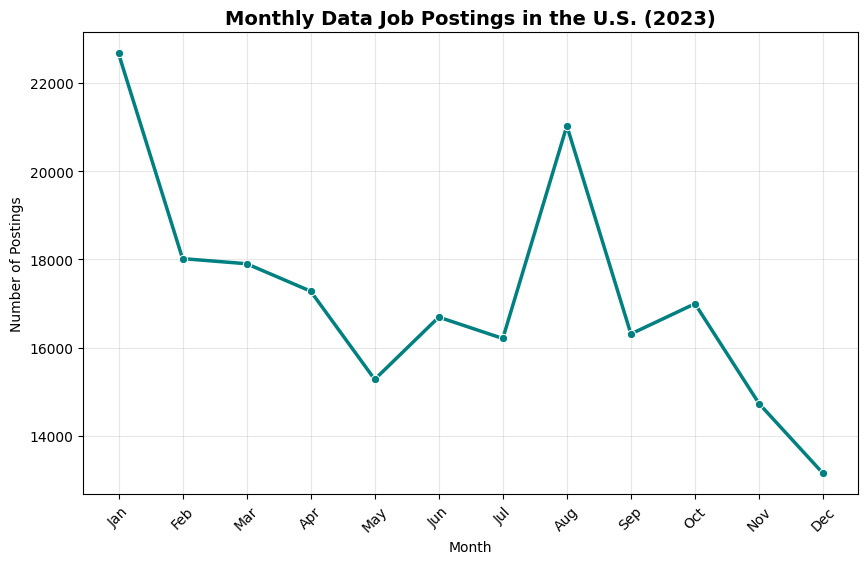

In [2]:
# Extract month and create a new column for better readability
df_US['month'] = df_US['job_posted_date'].dt.strftime('%b')  # e.g., Jan, Feb
df_US['month_num'] = df_US['job_posted_date'].dt.month       # numeric for sorting

# Group by month and count postings
monthly_trends = (
    df_US.groupby(['month_num','month'])
    .size()
    .reset_index(name='postings')
    .sort_values('month_num')
)

# Plot monthly trend
plt.figure(figsize=(10,6))
sns.lineplot(data=monthly_trends, x='month', y='postings', marker='o', linewidth=2.5, color='teal')
plt.title("Monthly Data Job Postings in the U.S. (2023)", fontsize=14, weight='bold')
plt.xlabel("Month")
plt.ylabel("Number of Postings")
plt.xticks(rotation=45)
plt.grid(alpha=0.3)
plt.show()


### Most Demanded Skills in the U.S. for Top 3 Data Roles

I begin by analyzing the most frequently requested skills for the three most popular data roles as seen in the EDA section:  
**Data Analyst, Data Engineer, and Data Scientist.**

This section highlights:
- Which technical skills dominate the U.S. job market.  
- The relative likelihood of each skill being requested in job postings.  
- Overlap and differences in skills across the top roles.  

Understanding these patterns provides clarity on the skillsets employers value most in different data career paths.

### Top Skills for Data Analyst, Data Engineer, and Data Scientist Roles (U.S.)

The chart below shows the five most frequently requested skills for each of the top three data roles in the U.S. job market.  
SQL and Python dominate across all roles, highlighting their importance as universal requirements.  
Visualization tools such as Tableau and Excel appear strongly for Data Analysts, while cloud technologies (AWS, Azure, Spark) are more associated with Data Engineers.  
Data Scientists stand out with higher demand for Python and R, reflecting the emphasis on statistical programming and machine learning.


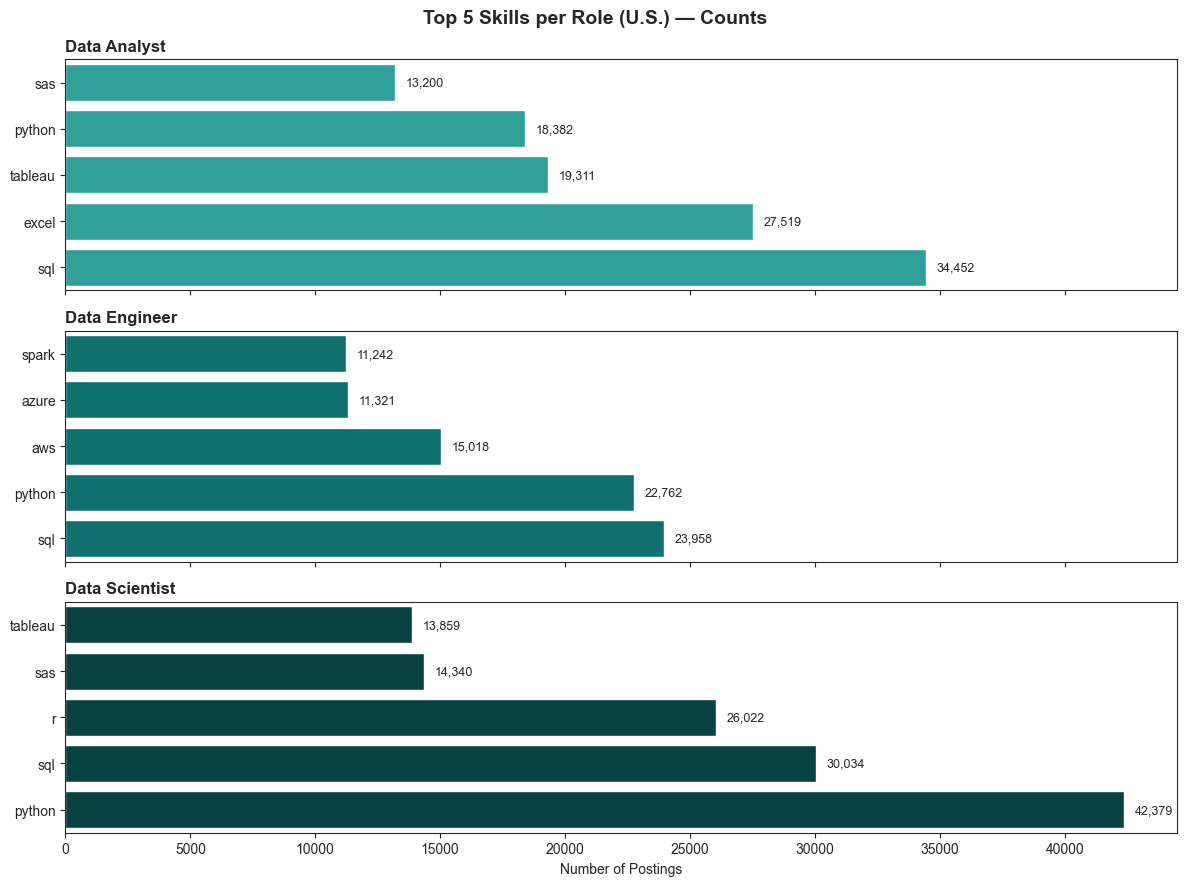

In [3]:
# Define top roles and their teal shades
top_roles = ["Data Analyst", "Data Engineer", "Data Scientist"]
role_colors = {
    "Data Analyst": "#20B2AA",  # Light Teal
    "Data Engineer": "#008080", # Medium Teal
    "Data Scientist": "#004C4C" # Dark Teal
}

# Filter and explode
df_top_roles = df_US[df_US['job_title_short'].isin(top_roles)].copy()
df_top_roles = df_top_roles.explode('job_skills')

# Count skills per role
skill_counts = (
    df_top_roles.groupby(['job_title_short','job_skills'])
    .size()
    .reset_index(name='count')
)

# Keep top 5 per role
top5_per_role = (
    skill_counts.sort_values(['job_title_short','count'], ascending=[True, False])
    .groupby('job_title_short', group_keys=False)
    .head(5)
)

# ----- Small multiples: one subplot per role -----
sns.set_style("ticks")
fig, axes = plt.subplots(nrows=len(top_roles), ncols=1, figsize=(12, 9), sharex=True)

if len(top_roles) == 1:
    axes = [axes]  # ensure iterable if only one role

max_count = top5_per_role['count'].max()

for ax, role in zip(axes, top_roles):
    sub = (top5_per_role[top5_per_role['job_title_short'] == role]
           .sort_values('count', ascending=True))  # ascending for horizontal bars
    sns.barplot(
        data=sub,
        x='count',
        y='job_skills',
        ax=ax,
        color=role_colors[role]  # each role gets its own teal shade
    )
    ax.set_title(role, loc="left", fontsize=12, weight="bold")
    ax.set_ylabel("")  # cleaner
    ax.set_xlabel("Number of Postings")

    # Value labels
    for p in ax.patches:
        w = p.get_width()
        ax.text(w + max_count * 0.01, p.get_y() + p.get_height()/2,
                f"{int(w):,}", va="center", fontsize=9)

fig.suptitle("Top 5 Skills per Role (U.S.) — Counts", fontsize=14, weight="bold", y=0.98)
plt.tight_layout()
plt.show()

While raw counts highlight which skills appear most often in postings, they don’t reveal how essential each skill is within a role.  
For example, SQL may dominate in absolute numbers, but what proportion of Data Analyst roles actually require it compared to Data Engineer or Data Scientist roles?  

To address this, the next visualization shifts from counts to **likelihoods (% of postings mentioning each skill)**, providing a clearer picture of the relative importance of each skill across roles.


### Likelihood of Skills Requested by Role (U.S.)

This heatmap illustrates the percentage of job postings that mention each skill, showing how likely it is for a role to require that skill.  
SQL and Python remain the most consistently required skills across all roles, appearing in over half of postings.  
Excel is disproportionately important for Data Analysts, while cloud platforms and big data tools (e.g., Spark, Azure, AWS) are heavily favored in Data Engineer postings.  
The comparison highlights not just what skills are popular, but how essential they are for each career path.


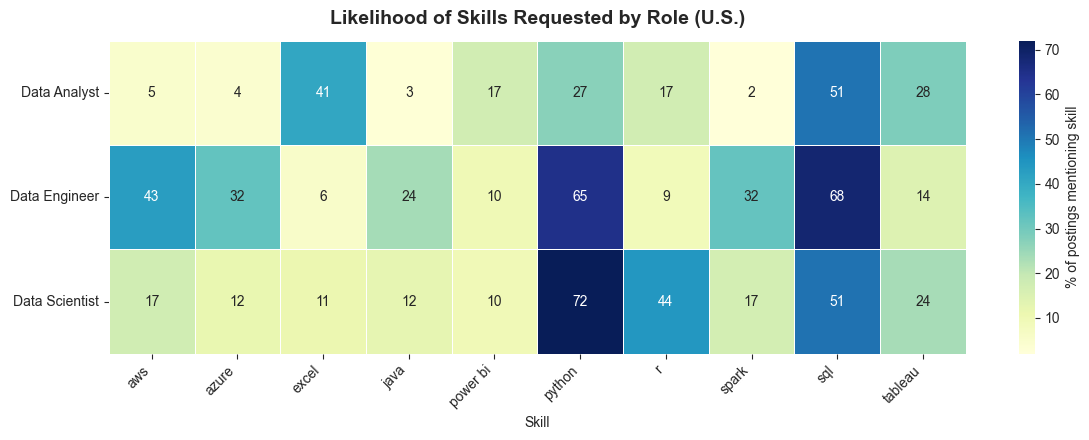

In [4]:
# Reuse df_top_roles from earlier (already exploded for job_skills)

# Use index as unique posting id
df_top_roles['post_id'] = df_top_roles.index  

# Total postings per role
totals = df_top_roles.groupby('job_title_short')['post_id'].nunique()

# Skill counts (unique postings per role/skill)
counts = df_top_roles.groupby(['job_title_short','job_skills'])['post_id'].nunique()

# % likelihood
pct = (counts.div(totals, level=0) * 100).reset_index(name='pct')

# Top N skills overall
top_skills = counts.groupby('job_skills').sum().nlargest(10).index

# Pivot to role × skill matrix
heat = pct[pct['job_skills'].isin(top_skills)].pivot(
    index='job_title_short', columns='job_skills', values='pct'
)

# Plot heatmap
plt.figure(figsize=(12,4.5))
sns.heatmap(heat, annot=True, fmt=".0f", cmap="YlGnBu",
            linewidths=.5, linecolor='white',
            cbar_kws={'label': '% of postings mentioning skill'})
plt.title("Likelihood of Skills Requested by Role (U.S.)", fontsize=14, weight="bold", pad=12)
plt.xlabel("Skill"); plt.ylabel("")
plt.yticks(rotation=0); plt.xticks(rotation=45, ha='right')
plt.tight_layout(); plt.show()

### Trends in In-Demand Skills for Data Analysts (U.S.)

Having identified the most in-demand skills across data roles, I now focus on how these skills are trending over time specifically for **Data Analyst positions** in the U.S. job market.  

By examining monthly patterns, we can observe whether certain tools and technologies (e.g., SQL, Excel, Tableau, Python) are gaining or losing traction.  
This trend analysis provides valuable insight into shifts in employer priorities, helping data professionals anticipate which skills may become more critical in the near future.

### Monthly Trends of Top Skills in Data Analyst Postings (U.S., 2023)

The chart below shows how demand for the top skills in Data Analyst job postings has changed month by month in 2023.  
Both the raw monthly counts (faint lines) and a 3-month rolling average (bold lines) are displayed.  

The rolling average helps to smooth out short-term fluctuations and seasonal noise, making the overall direction of each skill easier to see.  
For example, while SQL and Excel show month-to-month bumps, their smoothed lines confirm they remain consistently dominant.  
Python and Tableau display steadier demand, while SAS shows a gradual decline across the year.


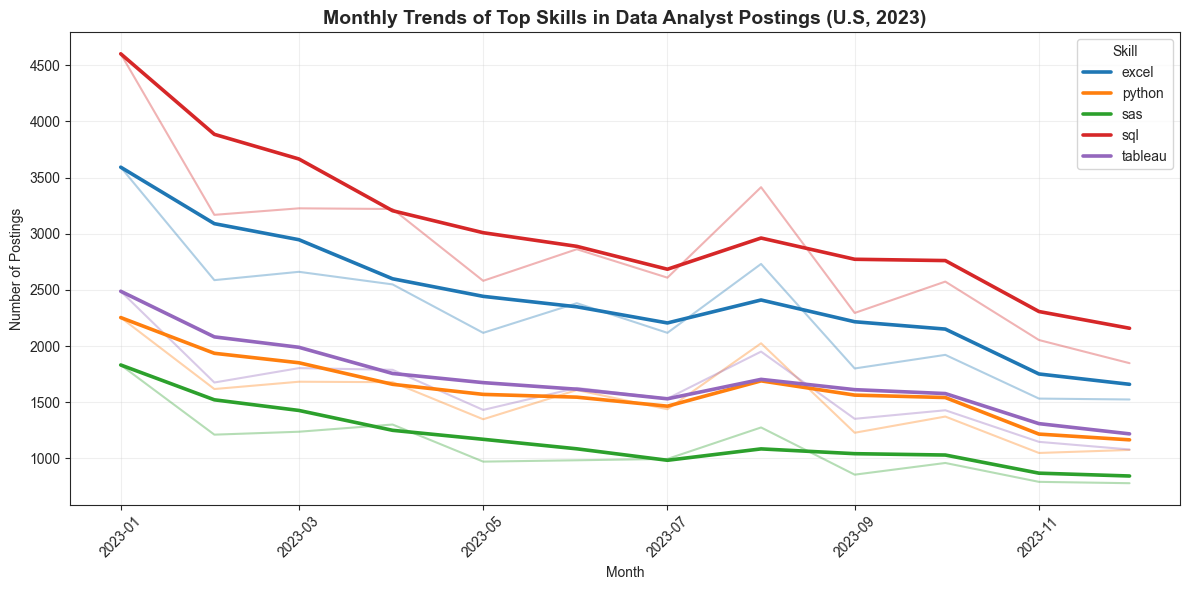

In [5]:
# Filter for Data Analyst postings only
df_DA_US = df_US[df_US['job_title_short'] == 'Data Analyst'].copy()

# Build a real month timestamp from job_posted_date (first day of month)
df_DA_US['month_ts'] = pd.to_datetime(df_DA_US['job_posted_date']).dt.to_period('M').dt.to_timestamp()

# 2) Explode skills and keep non-missing
df_DA_US = df_DA_US.explode('job_skills')
df_DA_US = df_DA_US[df_DA_US['job_skills'].notna()]

# 3) Monthly counts per skill
monthly = (
    df_DA_US.groupby(['month_ts','job_skills'])
    .size()
    .reset_index(name='count')
)

# 4) Pick top 5 skills overall (by total 2023 counts)
top_skills = (
    monthly.groupby('job_skills')['count']
    .sum()
    .nlargest(5)
    .index
)
monthly = monthly[monthly['job_skills'].isin(top_skills)]

# 5) Pivot to month x skill, compute 3-month rolling average
pivot = monthly.pivot_table(index='month_ts', columns='job_skills', values='count', aggfunc='sum').sort_index()
roll3 = pivot.rolling(window=3, min_periods=1).mean()

# 6) Plot: faint raw + thick smoothed
plt.figure(figsize=(12,6))
sns.lineplot(data=pivot, dashes=False, alpha=0.35, linewidth=1.5, legend = False)      # raw
sns.lineplot(data=roll3, dashes=False, linewidth=2.6)                   # smoothed
plt.title("Monthly Trends of Top Skills in Data Analyst Postings (U.S, 2023)", fontsize=14, weight='bold')
plt.xlabel("Month"); plt.ylabel("Number of Postings")
plt.xticks(rotation=45)
plt.grid(alpha=0.3)
plt.legend(title="Skill")
plt.tight_layout(); plt.show()


While the rolling average trends highlight how the absolute number of postings mentioning each skill changes over time, they are still influenced by overall hiring volume.  
For example, when job postings drop in December, all skills appear to decline together.  

To better understand the relative importance of each skill, the next chart normalizes demand by showing the **percentage of postings** that mention each skill.  
This perspective reveals whether a skill’s share of demand is growing, stable, or shrinking, regardless of fluctuations in total job postings.


### Monthly Percentage Trends of Top Skills in Data Analyst Postings (U.S., 2023)

This chart shows the relative importance of key skills for Data Analyst roles by tracking the percentage of job postings that mention each skill month by month.  

Unlike raw counts, this view removes the effect of overall job posting volume and highlights how each skill’s share of demand changes through the year.  
SQL consistently maintains the highest share of postings, confirming its role as a core requirement.  
Excel and Tableau show steady demand, while Python’s presence remains stable but slightly lower in proportion.  
SAS continues to decline in relative importance, reinforcing the shift away from legacy tools in favor of modern programming and visualization technologies.


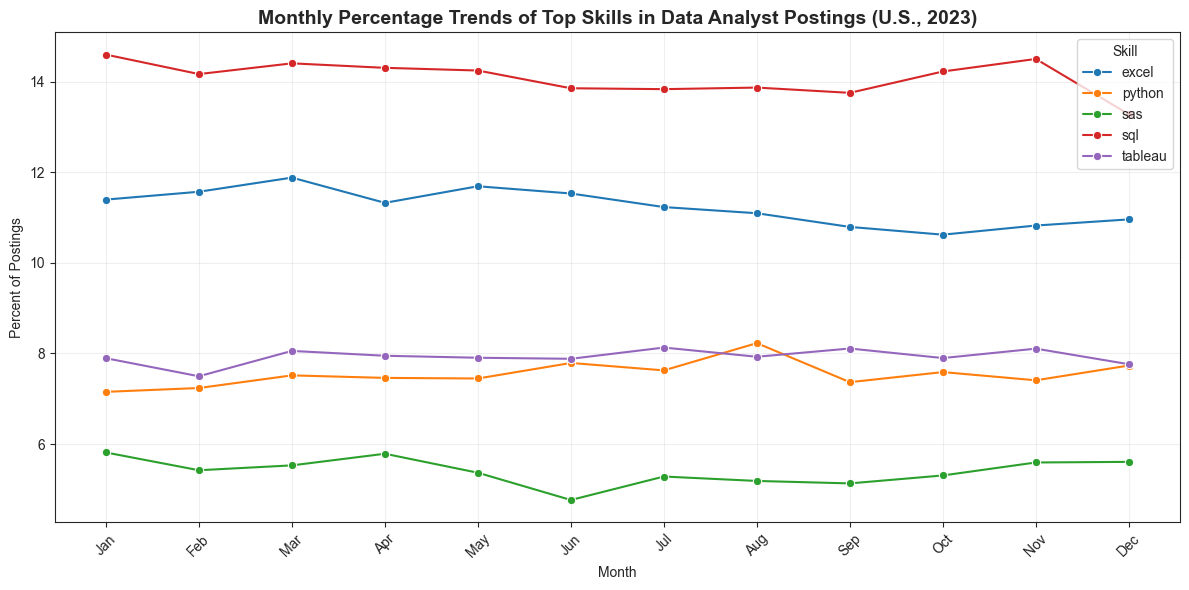

In [6]:
# Using the filtered dataset for Data Analyst postings, with exploded job_skills column
# Counts per (month_num, skill)
monthly_counts = (
    df_DA_US.groupby(['month_num','job_skills'])
    .size()
    .reset_index(name='count')
)

# Totals per month_num
monthly_totals = df_DA_US.groupby('month_num').size().reset_index(name='total')

# Merge + percentage
monthly_counts = monthly_counts.merge(monthly_totals, on='month_num', how='left')
monthly_counts['pct'] = 100 * monthly_counts['count'] / monthly_counts['total']

# Pick top 5 skills overall (by total count across months)
top_skills = (
    monthly_counts.groupby('job_skills')['count']
    .sum()
    .nlargest(5)
    .index
)
monthly_pct = monthly_counts[monthly_counts['job_skills'].isin(top_skills)].copy()

# Month labels in correct order 
month_labels = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']

# Plot
plt.figure(figsize=(12,6))
sns.lineplot(data=monthly_pct.sort_values('month_num'),
             x='month_num', y='pct', hue='job_skills', marker='o')
plt.title("Monthly Percentage Trends of Top Skills in Data Analyst Postings (U.S., 2023)", fontsize=14, weight='bold')
plt.xlabel("Month"); plt.ylabel("Percent of Postings")
plt.xticks(ticks=range(1,13), labels=month_labels, rotation=45)
plt.grid(alpha=0.3)
plt.legend(title="Skill", loc = "upper right")
plt.tight_layout()
plt.show()


### Summary of Skills Trend Analysis

The trend analysis confirms that **SQL** remains the dominant skill for Data Analyst roles, both in absolute demand and in relative share of postings.  
**Excel** and **Tableau** continue to play a central role in day-to-day analyst tasks, with steady demand throughout the year.  
**Python** shows consistent presence, reflecting its importance for analysts working with automation and advanced analytics.  
Meanwhile, **SAS** continues to decline, reinforcing the industry’s shift away from older statistical tools.  

By combining both raw demand (rolling averages) and relative importance (percentages), this section provides a clearer picture of not only *how many jobs* require each skill, but also *how critical each skill is within the Data Analyst toolkit*.  

### Forecasting Skill Demand (2024 and beyond)

To extend the analysis beyond descriptive insights, I built simple time-series forecasts to anticipate how demand for key skills may evolve into 2024 and beyond. 

I experimented with three different approaches:

- **Linear Regression**: Initially tested as a straightforward forecast. However, it assumes a straight-line trend and ignores seasonality. In practice, it gave unrealistic results (e.g., predicting negative postings), so it was not suitable for this dataset.  

- **ARIMA (AutoRegressive Integrated Moving Average)**: A classic baseline method in time series forecasting, but the results were unstable for this dataset. With only 12 months of history and visible seasonal variation, ARIMA produced unrealistic expectations. This highlighted the need for more seasonality aware models.  

- **SARIMA (Seasonal ARIMA):**  
  An extension of ARIMA that explicitly incorporates seasonality. SARIMA provided more stable forecasts for SQL and Python, making it a suitable short-term projection tool when limited data history is available.

- **Prophet**: A modern forecasting tool designed for business data. Prophet automatically handles trend and seasonal patterns (like hiring dips in December or mid-year peaks). To illustrate, I applied Prophet to both SQL and Python postings, as they represent core skills with different demand profiles.  

I combined both **SARIMA** and **Prophet** to provide a more balanced picture of how skill demand is likely to evelove rather than relying on a single method. 


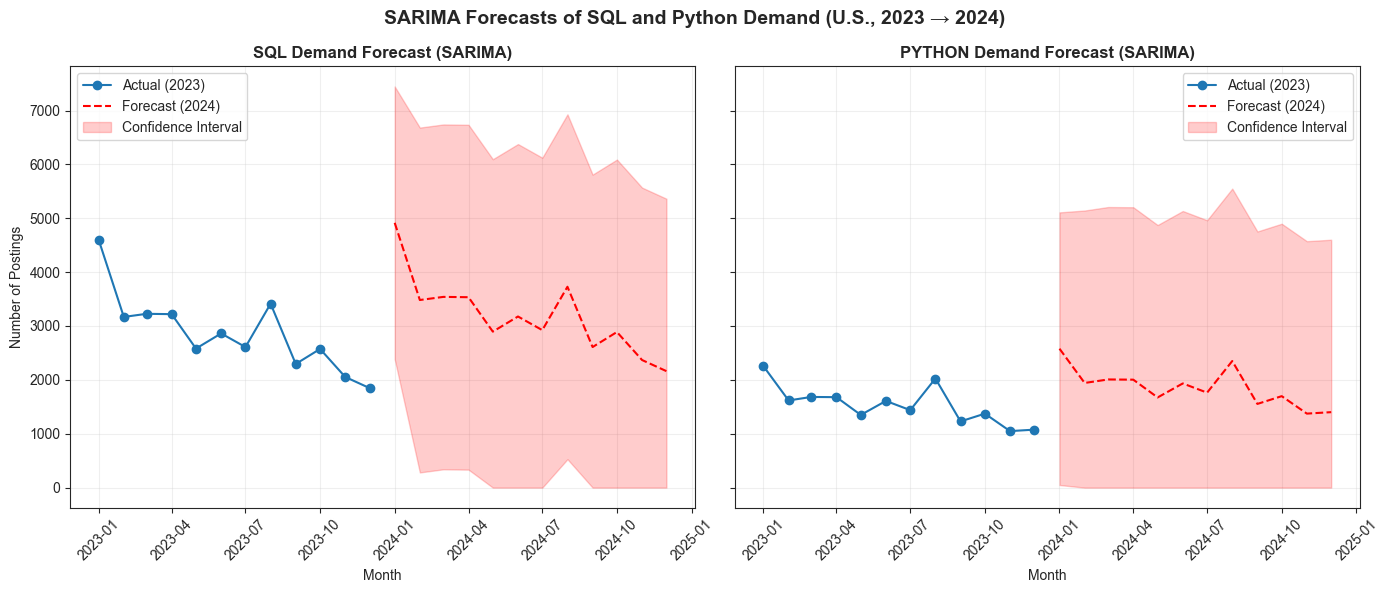

In [7]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
import warnings
warnings.filterwarnings("ignore")

def sarima_forecast(monthly_df, skill, steps=12, order=(1,1,1), seasonal_order=(1,1,1,12)):
    # Build monthly series for the skill and set monthly frequency
    s = (monthly_df[monthly_df['job_skills'] == skill]
         .groupby('month_ts')['count'].sum()
         .sort_index()
         .asfreq('MS'))

    # Fit SARIMA
    model = SARIMAX(s, order=order, seasonal_order=seasonal_order,
                    enforce_stationarity=False, enforce_invertibility=False)
    fit = model.fit(disp=False)

    # Forecast
    fc = fit.get_forecast(steps=steps)
    fc_df = fc.summary_frame()

    return s, fc_df


# Skills to forecast
skills = ['sql', 'python']
results = {sk: sarima_forecast(monthly, sk) for sk in skills}

# Plot side-by-side subplots
fig, axes = plt.subplots(1, 2, figsize=(14,6), sharey=True)

for ax, sk in zip(axes, skills):
    s, fc_df = results[sk]
    ax.plot(s.index, s.values, marker='o', label='Actual (2023)')
    ax.plot(fc_df.index, fc_df['mean'], '--', color='red', label='Forecast (2024)')
    ax.fill_between(fc_df.index, fc_df['mean_ci_lower'].clip(lower=0),
                    fc_df['mean_ci_upper'], color='red', alpha=0.2,
                    label='Confidence Interval')
    ax.set_title(f"{sk.upper()} Demand Forecast (SARIMA)", fontsize=12, weight='bold')
    ax.set_xlabel("Month")
    ax.tick_params(axis='x', rotation=45)
    if ax == axes[0]:
        ax.set_ylabel("Number of Postings")
    ax.grid(alpha=0.3)
    ax.legend()

plt.suptitle("SARIMA Forecasts of SQL and Python Demand (U.S., 2023 → 2024)", fontsize=14, weight='bold')
plt.tight_layout()
plt.show()

11:14:59 - cmdstanpy - INFO - Chain [1] start processing
11:14:59 - cmdstanpy - INFO - Chain [1] done processing
11:14:59 - cmdstanpy - INFO - Chain [1] start processing
11:14:59 - cmdstanpy - INFO - Chain [1] done processing


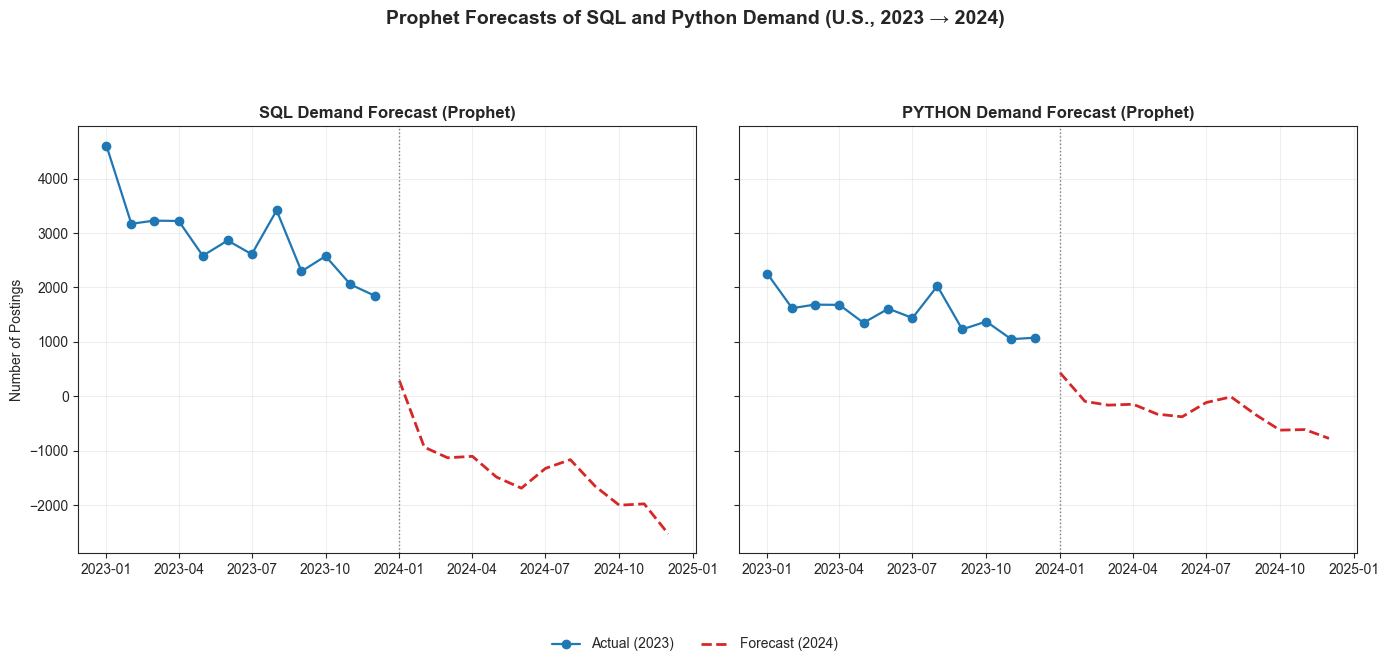

In [8]:
from prophet import Prophet
import pandas as pd
import matplotlib.pyplot as plt
import warnings, logging, contextlib, os
warnings.filterwarnings("ignore")
logging.getLogger("cmdstanpy").setLevel(logging.CRITICAL)
logging.getLogger("prophet").setLevel(logging.CRITICAL)

def make_monthly_series(monthly_df, skill):
    # Filter, aggregate to monthly, ensure continuous months
    df = (monthly_df[monthly_df['job_skills'].astype(str).str.lower() == skill.lower()]
          .loc[:, ['month_ts','count']].copy())
    df['ds'] = pd.to_datetime(df['month_ts']).dt.to_period('M').dt.to_timestamp()
    df = (df.groupby('ds', as_index=False)['count'].sum()
            .rename(columns={'count':'y'})
            .sort_values('ds', ignore_index=True))
    idx = pd.date_range(df['ds'].min(), df['ds'].max(), freq='MS')
    df = (df.set_index('ds').reindex(idx, fill_value=0)
            .rename_axis('ds').reset_index())
    # scale for numerical stability
    df['y_scaled'] = df['y'] / 1000.0
    return df

def prophet_forecast_stable(df, steps=12):
    m = Prophet(
        yearly_seasonality=False,
        weekly_seasonality=False,
        daily_seasonality=False,
        changepoint_prior_scale=0.15,
        seasonality_mode='additive',
        uncertainty_samples=0,    # deterministic
    )
    m.add_seasonality(name='yearly', period=365.25, fourier_order=3)

    # y_scaled (renamed to y) to avoid duplicate 'y'
    fit_df = df[['ds','y_scaled']].rename(columns={'y_scaled':'y'})

    with open(os.devnull, "w") as devnull, contextlib.redirect_stdout(devnull), contextlib.redirect_stderr(devnull):
        m.fit(fit_df)
        future = m.make_future_dataframe(periods=steps, freq='MS')
        fc = m.predict(future)

    last_hist = df['ds'].max()
    fut = fc[fc['ds'] > last_hist].copy()
    # unscale back
    fut['yhat'] = fut['yhat'] * 1000.0
    return last_hist, fut

# Build & forecast for SQL + Python
skills = ['sql','python']
data = {s: make_monthly_series(monthly, s) for s in skills}
results = {s: prophet_forecast_stable(data[s], steps=12) for s in skills}

# Plot
fig, axes = plt.subplots(1, 2, figsize=(14,6), sharey=True)
for ax, s in zip(axes, skills):
    df = data[s]
    last_hist, fut = results[s]
    ax.plot(df['ds'], df['y'], marker='o', linewidth=1.6, label='Actual (2023)')
    ax.plot(fut['ds'], fut['yhat'], '--', color='tab:red', linewidth=2.0, label='Forecast (2024)')
    ax.axvline(last_hist + pd.offsets.MonthBegin(1), color='gray', linestyle=':', linewidth=1)
    ax.set_title(f"{s.upper()} Demand Forecast (Prophet)", fontsize=12, weight='bold')
    ax.set_xlabel(""); ax.grid(alpha=0.3)

axes[0].set_ylabel("Number of Postings")
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=3, frameon=False, bbox_to_anchor=(0.5, -0.06))
fig.suptitle("Prophet Forecasts of SQL and Python Demand (U.S., 2023 → 2024)", fontsize=14, weight='bold', y=1.03)
plt.tight_layout(rect=[0,0.06,1,0.95])
plt.show()


### Summary of Forecasting Analysis (SQL & Python)

To project how demand for SQL and Python may evolve into 2024, two models were applied:

- **SARIMA (Seasonal ARIMA):**  
  - SQL: The model suggests a continued downward trend in demand, with wide confidence intervals indicating uncertainty.  
  - Python: Demand is also projected to decline modestly, though confidence intervals remain broad, highlighting forecast volatility.  

- **Prophet (Meta/Facebook):**  
  - SQL: Forecast indicates a clear decline throughout 2024, with less seasonal fluctuation compared to SARIMA.  
  - Python: Shows steadier demand compared to SQL, though the model still projects a gradual decrease.  

**Takeaway:** Both models agree that SQL demand may face a sharper decline in 2024, while Python is more resilient but not immune to downward pressure. Prophet provides smoother, seasonality-aware forecasts, whereas SARIMA highlights uncertainty bands more strongly. Using both perspectives balances robustness (SARIMA) with interpretability (Prophet).  


These insights set the stage for the next section, where I evaluate how these skills connect to **salary trends and earning potential**.
